<a href="https://colab.research.google.com/github/zcakg86/house-sales-king-county/blob/main/house_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load packages

In [ ]:
import pandas as pd
import os
from google.colab import drive
from google.colab import data_table
data_table.enable_dataframe_formatter()
#drive.mount('/content/drive/')
# use seaborn for eda?
import seaborn as sns
# use plotly for app
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# geospatial
import geopandas
!pip install pysal
import pysal # for spatial weights
import spreg #spatial regression


 # machine
#!pip install pyspark
#if want spark https://colab.research.google.com/drive/1fa2G3YuXx3Isqyby5kFETqmWotFwtqlH?usp=sharing
import numpy as np # for vectorisation
import tensorflow as tf
# import scikitlearr

os.chdir('/content/drive/MyDrive/house-sales/data/')
# example create file
!touch "../functions/main.py"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━

<Axes: >

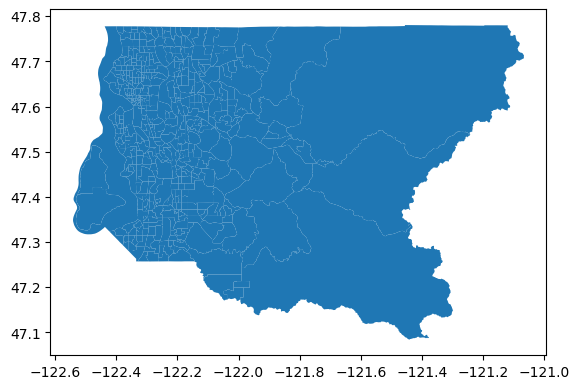

In [ ]:
# load census tracts
census_tracts_king_co = geopandas.read_file('2020_Census_Tracts_for_King_County___tracts20_area.geojson')
census_tracts_king_co.plot()

In [ ]:
# read csv
sales = pd.read_csv('kingco_sales.csv')


### Check data

In [ ]:
display(sales.dtypes)

Unnamed: 0            int64
sale_id              object
pinx                 object
sale_date            object
sale_price            int64
sale_nbr            float64
sale_warning         object
join_status          object
join_year             int64
latitude            float64
longitude           float64
area                  int64
city                 object
zoning               object
subdivision          object
present_use           int64
land_val              int64
imp_val               int64
year_built            int64
year_reno             int64
sqft_lot              int64
sqft                  int64
sqft_1                int64
sqft_fbsmt            int64
grade                 int64
fbsmt_grade           int64
condition             int64
stories             float64
beds                  int64
bath_full             int64
bath_3qtr             int64
bath_half             int64
garb_sqft             int64
gara_sqft             int64
wfnt                  int64
golf                

### Transform dataset

#### Encode Dates

In [ ]:
def code_dates(data, date_column, input_format = '%Y-%m-%d', add_month_year = False):
  data["sale_date"] = pd.to_datetime(data[date_column], format=input_format)
  if add_month_year == True:
    #data["sale_year"] = data["sale_date"].dt.year
    #data["sale_month"] = data["sale_date"].dt.month
    data["sale_year_month"] = data["sale_date"].dt.to_period("M")
    #data["year_month"] = data["sale_year_month"].astype(str)
  return(data)
#test
test = pd.DataFrame(data = {'date' : ['2000-03-01','2000-04-01','2001-03-01','2000-03-31']})
test = code_dates(data = test, date_column = 'date', input_format = '%Y-%m-%d')
test

,date,sale_date
0,2000-03-01,2000-03-01
1,2000-04-01,2000-04-01
2,2001-03-01,2001-03-01
3,2000-03-31,2000-03-31


#### Add months from date function

In [ ]:

def add_months_passing(data, column, start_date = None):
 # Takes latest month and calculates difference from there
  if start_date == None:
    start_date = data[column].dt.to_period('M').astype(int).max()
 # Unless you pass a start_date and then it calculates from there
  else:
    print(start_date)
    date = pd.DataFrame(data = {'start_date' : [start_date]})
    date['start_date'] = pd.to_datetime(date['start_date'], format='%Y-%m-%d')
    start_date = date['start_date'].dt.to_period('M').astype(int).max()

  data['months_difference'] = data[column].dt.to_period('M').astype(int) - start_date
  return(data)

add_months_passing(test, column = 'sale_date',start_date = "2001-03-31")
#add_months_passing(sales, column = 'sale_date',start_date = None)

2001-03-31


,date,sale_date,months_difference
0,2000-03-01,2000-03-01,-12
1,2000-04-01,2000-04-01,-11
2,2001-03-01,2001-03-01,0
3,2000-03-31,2000-03-31,-12


#### select column function

In [ ]:
import re
# specify list of strings, that if that string is in a column name, a dataset is returned with all matching columns
# use the full column name or parts of it e.g.  'view' to contain columns including view_lake, view_ocean

def columns_contain_string(data, strings):
  """specify string, or list of strings, as {strings}, and return list of these columns present in data"""
  regex = ''
  if type(strings) == list:
     for i in range(len(strings)):
        regex = regex + '|' + strings[i]
     #remove first |
     regex = regex[1:]
     print(f'Regex used is {regex}')
  elif type(strings) == str:
    print(f'Parsing "{strings}" as pattern for regex. Function expects list of strings as patterns')
    regex = strings

  cols = list(data.columns)
  cols_keep = list(filter(lambda k: re.search(regex,k), cols))
  return(cols_keep)


def select_columns(data, strings):
  """specify string, or list of strings, as {strings}, and return data with columns containing these strings only """
  regex = ''
  if type(strings) == list:
     for i in range(len(strings)):
        regex = regex + '|' + strings[i]
     #remove first |
     regex = regex[1:]
     print(f'Regex used is {regex}')
  elif type(strings) == str:
    print(f'Parsing "{strings}" as pattern for regex. Function expects list of strings as patterns')
    regex = strings

  cols = list(data.columns)
  cols_keep = list(filter(lambda k: re.search(regex,k), cols))
  return(data[cols_keep])


#prepare_dataset(data = test, strings = ['year_month','date'])
select_columns(data = test, strings = 'date')


Parsing "date" as pattern for regex. Function expects list of strings as patterns


,date,sale_date
0,2000-03-01,2000-03-01
1,2000-04-01,2000-04-01
2,2001-03-01,2001-03-01
3,2000-03-31,2000-03-31


#### Add binary columns for months

In [ ]:
import re
# could use pd.get_dummies()
def add_month_binary_cols(data, months_column, start = None, end = None):
  if start is None:
    start = data[months_column].min()
  if end is None:
    end = data[months_column].max()

  date_range = range(start, end + 1)
  for i in date_range:
    m = re.sub('-','neg',str(i))
    data[f'{months_column}_{m}'] = (data[months_column] == i).astype(int)
  return(data)

test2 = add_months_passing(test, column = 'sale_date',start_date = "2001-03-31")
add_month_binary_cols(test2, "months_difference", start = -12, end = 0)


2001-03-31


,date,sale_date,months_difference,months_difference_neg12,months_difference_neg11,months_difference_neg10,months_difference_neg9,months_difference_neg8,months_difference_neg7,months_difference_neg6,months_difference_neg5,months_difference_neg4,months_difference_neg3,months_difference_neg2,months_difference_neg1,months_difference_0
0,2000-03-01,2000-03-01,-12,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2000-04-01,2000-04-01,-11,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2001-03-01,2001-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2000-03-31,2000-03-31,-12,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Add months to sales data

In [ ]:
# read csv
sales = pd.read_csv('kingco_sales.csv')

sales = code_dates(sales, 'sale_date', add_month_year = True)
sales = sales.loc[sales["sale_date"].dt.year == 2023]
sales = add_months_passing(sales, 'sale_date')
sales = add_month_binary_cols(sales,"months_difference", end = 0)
# add dummies for beds
sales = pd.get_dummies(sales,columns = ["beds"])
# add dummmies for submarket
sales = pd.get_dummies(sales,columns = ["submarket"])
# add dummmies for grade
sales = pd.get_dummies(sales,columns = ["grade"])
sales.shape

<ipython-input-5-1e7b1433f4d5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['months_difference'] = data[column].dt.to_period('M').astype(int) - start_date
<ipython-input-7-f293d2618aa8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{months_column}_{m}'] = (data[months_column] == i).astype(int)
<ipython-input-7-f293d2618aa8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

(15944, 101)

In [ ]:
sales

,Unnamed: 0,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
6063,6064,2023..37,..0625049021,2023-01-02,1300000,2.0,26,demo,1999,47.687533,...,0,0,0,0,1,0,0,0,0,0
6064,6065,2023..70,..4070700110,2023-01-04,1953250,4.0,,demo,1999,47.673088,...,0,0,1,0,0,0,0,0,0,0
6065,6066,2023..234,..6132600280,2023-01-09,750000,2.0,,demo,1999,47.700323,...,0,1,0,0,0,0,0,0,0,0
6066,6067,2023..300,..6147600264,2023-01-04,875600,2.0,,demo,1999,47.391434,...,0,0,0,1,0,0,0,0,0,0
6067,6068,2023..400,..4338200270,2023-01-09,690000,2.0,15,demo,1999,47.480894,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575314,575315,2023..26181,..9412700500,2023-12-20,595000,4.0,,reno - before,2023,47.393370,...,0,0,0,1,0,0,0,0,0,0
575315,575316,2023..26200,..7628700230,2023-12-13,875000,4.0,,reno - before,2023,47.571076,...,0,0,0,0,1,0,0,0,0,0
575316,575317,2023..26205,..9471200030,2023-12-14,2025000,2.0,,reno - before,2023,47.670817,...,0,0,0,0,0,0,1,0,0,0
575317,575318,2023..26232,..0425500130,2023-12-14,825000,4.0,,reno - before,2023,47.500221,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
pd.DataFrame(sales.dtypes)

,0
Unnamed: 0,int64
sale_id,object
pinx,object
sale_date,datetime64[ns]
sale_price,int64
...,...
beds_5,uint8
beds_6,uint8
beds_7,uint8
beds_8,uint8


In [ ]:
sales.iloc[1:100,-10:]

,submarket_J,submarket_K,submarket_L,submarket_M,submarket_N,submarket_O,submarket_P,submarket_Q,submarket_R,submarket_S
6064,0,0,0,0,0,0,0,1,0,0
6065,0,0,0,0,0,0,0,0,0,0
6066,0,0,1,0,0,0,0,0,0,0
6067,0,0,0,0,0,0,0,0,0,0
6068,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6158,0,0,0,0,0,0,0,0,0,0
6159,0,0,0,0,0,0,0,0,0,0
6160,0,0,0,0,0,0,0,0,0,0
6161,0,0,0,0,0,0,0,0,1,0


## First model - regression


### Set up data


In [ ]:
#from sklearn.linear_model import LinearRegression
#from pyspark.ml.regression import LinearRegression

X = select_columns(sales,["months_difference_","sqft","beds_","submarket_","grade_"]).to_numpy()
X_features = columns_contain_string(sales,["months_difference_","sqft","beds_","submarket_","grade_"])
y = select_columns(sales,["sale_price"]).to_numpy()
y_log = np.log(y)
y_norm = y/max(y)

# check shape ...
print(sales.shape, X.shape, y.shape)

Regex used is months_difference_|sqft|beds_|submarket_|grade_
Regex used is months_difference_|sqft|beds_|submarket_|grade_
Regex used is sale_price
(15944, 101) (15944, 59) (15944, 1)


In [ ]:
y_norm

array([[0.07869779],
       [0.11824343],
       [0.04540257],
       ...,
       [0.12258694],
       [0.04994283],
       [0.14074797]])

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg_log = LinearRegression().fit(X, y_log)
reg_norm = LinearRegression().fit(X, y_norm)

In [ ]:
print(reg.score(X, y))
# 0.3198 without submarket
# 0.5738 with submarkets
print(reg_log.score(X, y_log))
# 0.7085 with log transform prices & submarkets
# 0.7193 with log transform prices and grade & submarkets
print(reg_norm.score(X, y_norm))
# 0.5783 with normalised prices & submarkets

0.5990990485481358
0.7193122909886168
0.5990990485481358


In [ ]:
coef_dict = {}
for coef, feat in zip(reg_log.coef_.transpose(),X_features):
    coef_dict[feat] = coef

In [ ]:
pd.DataFrame(coef_dict)
# results.. need nested grade within submarket etc.

{'sqft_lot': array([3.40111029e-07]),
 'sqft': array([0.00020708]),
 'sqft_1': array([0.00010111]),
 'sqft_fbsmt': array([-2.44100099e-05]),
 'garb_sqft': array([-9.20993852e-05]),
 'gara_sqft': array([-1.05489562e-05]),
 'months_difference_neg11': array([-0.0647863]),
 'months_difference_neg10': array([-0.02582839]),
 'months_difference_neg9': array([-0.00511232]),
 'months_difference_neg8': array([0.01337339]),
 'months_difference_neg7': array([0.02686935]),
 'months_difference_neg6': array([0.03338582]),
 'months_difference_neg5': array([0.02040707]),
 'months_difference_neg4': array([0.01384993]),
 'months_difference_neg3': array([0.01187348]),
 'months_difference_neg2': array([-0.00474407]),
 'months_difference_neg1': array([0.00581017]),
 'months_difference_0': array([-0.02509815]),
 'beds_0': array([0.06350413]),
 'beds_1': array([0.07696434]),
 'beds_2': array([0.01131112]),
 'beds_3': array([0.04834069]),
 'beds_4': array([0.06096069]),
 'beds_5': array([0.05516065]),
 'beds_6

In [ ]:
y_pred = reg_log.predict(X)
y_pred = np.exp(y_pred)


y_pred_df = pd.DataFrame({"y_pred":y_pred[:,0]})
y_pred_df.shape


(15944, 1)

In [ ]:
sales = pd.concat([sales.reset_index(drop=True),y_pred_df.reset_index(drop=True)],axis = 1)
sales.shape

(15944, 102)

In [ ]:
sales["error"] = sales["y_pred"]-sales["sale_price"]

In [ ]:
sales.iloc[1:1000,[4,5,9,10,18,19,20,21,22,23,24,-1]]

,sale_price,sale_nbr,latitude,longitude,year_built,year_reno,sqft_lot,sqft,sqft_1,sqft_fbsmt,fbsmt_grade,error
1,1953250,4.0,47.673088,-122.203078,1942,0,6000,890,890,0,0,-1.176100e+06
2,750000,2.0,47.700323,-122.391086,1927,0,5250,760,760,0,0,1.206474e+04
3,875600,2.0,47.391434,-122.235677,1991,0,5080,1780,900,0,0,-3.778221e+05
4,690000,2.0,47.480894,-122.340127,1944,0,11250,1490,1490,0,0,-1.357113e+05
5,1250000,NaN,47.601260,-122.193948,1966,0,9443,2390,1480,910,7,8.178672e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1425000,3.0,47.571476,-122.378918,1946,1971,5000,1830,920,0,0,-5.924758e+05
996,1280000,3.0,47.571605,-122.104759,1937,1955,5000,1450,1450,0,0,-1.418907e+05
997,1100000,3.0,47.515178,-122.255790,1942,1994,5800,3070,1350,940,6,-2.985517e+05
998,1120000,4.0,47.711182,-122.352466,1937,1980,7530,1740,1740,0,0,-6.945922e+04


### Create GeoDataSeries with sales data

In [ ]:
sales_points = geopandas.GeoDataFrame(sales, geometry=geopandas.points_from_xy(sales.longitude, sales.latitude), crs="EPSG:4326")

In [ ]:
sales_points.head()

,Unnamed: 0,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,...,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,y_pred,error,geometry
0,6064,2023..37,..0625049021,2023-01-02,1300000,2.0,26,demo,1999,47.687533,...,0,1,0,0,0,0,0,1.105494e+06,-1.945062e+05,POINT (-122.33681 47.68753)
1,6065,2023..70,..4070700110,2023-01-04,1953250,4.0,,demo,1999,47.673088,...,0,0,0,0,0,0,0,7.771500e+05,-1.176100e+06,POINT (-122.20308 47.67309)
2,6066,2023..234,..6132600280,2023-01-09,750000,2.0,,demo,1999,47.700323,...,0,0,0,0,0,0,0,7.620647e+05,1.206474e+04,POINT (-122.39109 47.70032)
3,6067,2023..300,..6147600264,2023-01-04,875600,2.0,,demo,1999,47.391434,...,1,0,0,0,0,0,0,4.977779e+05,-3.778221e+05,POINT (-122.23568 47.39143)
4,6068,2023..400,..4338200270,2023-01-09,690000,2.0,15,demo,1999,47.480894,...,0,0,0,0,0,0,0,5.542887e+05,-1.357113e+05,POINT (-122.34013 47.48089)


In [ ]:
census_tracts_king_co.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,GEO_ID_TRT,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,TRACT_LBL2,Shape_Length,Shape_Area,geometry
0,1,53,033,000101,53033000101,1.01,Census Tract,G5020,S,414848,0,+47.7301150,-122.2930741,8662.100980,Tract 000101,8662.100980,4.465062e+06,"POLYGON ((-122.29654 47.73198, -122.29655 47.7..."
1,2,53,033,000102,53033000102,1.02,Census Tract,G5020,S,1495019,918878,+47.7247297,-122.2845705,22442.914577,Tract 000102,22442.914577,2.598103e+07,"POLYGON ((-122.29640 47.72651, -122.29638 47.7..."
2,3,53,033,000201,53033000201,2.01,Census Tract,G5020,S,1806749,0,+47.7263725,-122.3160435,18651.594451,Tract 000201,18651.594451,1.944625e+07,"POLYGON ((-122.32358 47.72130, -122.32359 47.7..."
3,4,53,033,000202,53033000202,2.02,Census Tract,G5020,S,1480085,0,+47.7269637,-122.3026174,17285.853332,Tract 000202,17285.853332,1.593036e+07,"POLYGON ((-122.31005 47.73392, -122.31003 47.7..."
4,5,53,033,000300,53033000300,3,Census Tract,G5020,S,1211013,0,+47.7305259,-122.3329277,17298.152149,Tract 000300,17298.152149,1.303428e+07,"POLYGON ((-122.34521 47.73413, -122.34521 47.7..."


### Add membership of Census Tract

In [ ]:
# sjoin method
sales_points = geopandas.sjoin(sales_points, census_tracts_king_co[["TRACTCE20","geometry"]], how="left", predicate ='within')
sales_points = sales_points.rename(columns={"TRACTCE20": "tract"})

In [ ]:
sales_points.columns

Index(['Unnamed: 0', 'sale_id', 'pinx', 'sale_date', 'sale_price', 'sale_nbr',
       'sale_warning', 'join_status', 'join_year', 'latitude',
       ...
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'y_pred',
       'error', 'geometry', 'index_right', 'tract'],
      dtype='object', length=106)

### run MLR with tract instead of submarket

In [ ]:
#sales_points = pd.get_dummies(sales_points, columns=["tract"])

exp_vars = ["months_difference_","\\bsqft\\b","beds_","tract_","grade_"]
X = select_columns(sales_points,exp_vars).to_numpy()
X_features = columns_contain_string(sales_points,exp_vars)
y = select_columns(sales_points,["sale_price"]).to_numpy()
y_log = np.log(y)

# check shape ...
print(sales_points.shape, X.shape, y.shape, X_features)

Regex used is months_difference_|\bsqft\b|beds_|tract_|grade_
Regex used is months_difference_|\bsqft\b|beds_|tract_|grade_
Regex used is sale_price
(15944, 561) (15944, 491) (15944, 1) ['sqft', 'months_difference_neg11', 'months_difference_neg10', 'months_difference_neg9', 'months_difference_neg8', 'months_difference_neg7', 'months_difference_neg6', 'months_difference_neg5', 'months_difference_neg4', 'months_difference_neg3', 'months_difference_neg2', 'months_difference_neg1', 'months_difference_0', 'beds_0', 'beds_1', 'beds_2', 'beds_3', 'beds_4', 'beds_5', 'beds_6', 'beds_7', 'beds_8', 'beds_9', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'tract_000101', 'tract_000102', 'tract_000201', 'tract_000202', 'tract_000300', 'tract_000402', 'tract_000403', 'tract_000404', 'tract_000500', 'tract_000601', 'tract_000602', 'tract_000700', 'tract_000800', 'tract_000900', 'tract_001000', 'tract_001100', 't

In [ ]:

from sklearn.feature_selection import f_regression
reg_log =
freg=f_regression(X,y_log)
reg_log = LinearRegression().fit(X, y_log)

p=freg[1]
p.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(491,)

In [ ]:
reg_log.coef_.transpose()[:,0].shape

(491,)

In [ ]:
coef_table = pd.DataFrame({"feature":X_features,
                           "coef": reg_log.coef_.transpose()[:,0],
                           "pvalue":p})


coef_table
# nonsense coef

,feature,coef,pvalue
0,sqft,2.077192e-04,0.000000e+00
1,months_difference_neg11,3.932839e+08,4.161170e-07
2,months_difference_neg10,3.932839e+08,2.523247e-05
3,months_difference_neg9,3.932839e+08,1.636493e-01
4,months_difference_neg8,3.932839e+08,9.125182e-01
...,...,...,...
486,tract_032703,-5.628171e+05,6.859196e-03
487,tract_032704,-5.628170e+05,1.077477e-02
488,tract_032705,-5.628170e+05,9.224112e-01
489,tract_032706,-5.628170e+05,6.280479e-01


## Pytorch set up

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import copy
import tqdm
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

NameError: name 'model' is not defined

In [ ]:
# split test/train data 0.7/0.3
from sklearn.model_selection import train_test_split
exp_cols = ["\\bsale_price\\b","months_difference_","\\bsqft\\b","beds_","grade_","\\blatitude\\b","\\blongitude\\b"]
X = select_columns(sales_points,exp_cols).to_numpy()
X_features = columns_contain_string(sales_points,exp_cols)

x_train, x_test = train_test_split(X, test_size = 0.3)
y_train = x_train[:,0]
y_test = x_test[:,0]
x_train = x_train[:,1:]
x_test = x_test[:,1:]
x_train = torch.tensor(x_train,dtype=torch.float32)
x_test = torch.tensor(x_test,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)



Regex used is \bsale_price\b|months_difference_|\bsqft\b|beds_|grade_|\blatitude\b|\blongitude\b
Regex used is \bsale_price\b|months_difference_|\bsqft\b|beds_|grade_|\blatitude\b|\blongitude\b
torch.Size([11160, 37]) torch.Size([4784, 37]) torch.Size([11160]) torch.Size([4784])


In [ ]:
# sense check y
y_test


tensor([1731000., 1480000.,  925450.,  ...,  425000.,  505000.,  500000.])

In [ ]:
X_features

['sale_price',
 'latitude',
 'longitude',
 'sqft',
 'months_difference_neg11',
 'months_difference_neg10',
 'months_difference_neg9',
 'months_difference_neg8',
 'months_difference_neg7',
 'months_difference_neg6',
 'months_difference_neg5',
 'months_difference_neg4',
 'months_difference_neg3',
 'months_difference_neg2',
 'months_difference_neg1',
 'months_difference_0',
 'beds_0',
 'beds_1',
 'beds_2',
 'beds_3',
 'beds_4',
 'beds_5',
 'beds_6',
 'beds_7',
 'beds_8',
 'beds_9',
 'grade_2',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13']

In [ ]:
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

print(model)

Sequential(
  (0): Linear(in_features=37, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
# code from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# training parameters
n_epochs = 10   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([4784])) that is different to the input size (torch.Size([4784, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



<All keys matched successfully>

In [ ]:
model.

TypeError: Module.get_parameter() missing 1 required positional argument: 'target'

In [ ]:
y_test1 = y_test.detach().numpy().copy()
y_pred1 = y_pred.squeeze().detach().numpy().copy()

fig = px.scatter(x=y_test1, y=y_pred1-y_test1)
fig.show()

In [ ]:
model

Sequential(
  (0): Linear(in_features=37, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
y_pred

tensor([[1347017.7500],
        [1029119.9375],
        [1061916.5000],
        ...,
        [ 759566.1875],
        [ 803123.5625],
        [1048457.0625]], grad_fn=<AddmmBackward0>)

MSE: 711364575232.00
RMSE: 843424.32


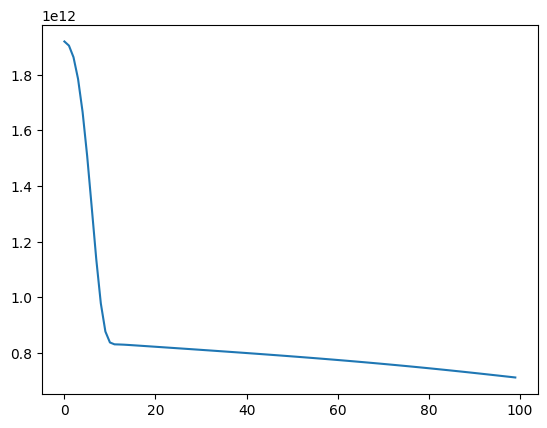

In [ ]:

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

## Monthly Aggregation

In [ ]:

monthly_counts = sales.astype({'sale_year_month': 'str'}).groupby(["sale_year_month","months_difference"])\
        .agg({'sale_id':'size', 'sale_price':'mean', 'sqft':'mean'})\
        .rename(columns={'sale_id':'count','sale_price':'mean_price','sqft':'mean_sqft'})\
        .reset_index()
monthly_counts['month_price_change'] = monthly_counts['mean_price'].pct_change(periods=1)*100
monthly_counts['year_price_change'] = monthly_counts['mean_price'].pct_change(periods=12)*100

#sales.groupby("sale_year_month")[mean_cols].mean()
display(monthly_counts)

,sale_year_month,months_difference,count,mean_price,mean_sqft,month_price_change,year_price_change
0,1999-01,-299,1387,2.743247e+05,2117.347513,NaN,NaN
1,1999-02,-298,1576,2.676150e+05,2072.910533,-2.445891,NaN
2,1999-03,-297,2186,2.711619e+05,2082.332113,1.325364,NaN
3,1999-04,-296,2166,2.855885e+05,2074.984765,5.320285,NaN
4,1999-05,-295,2213,2.786742e+05,2046.547673,-2.421067,NaN
...,...,...,...,...,...,...,...
295,2023-08,-4,1564,1.165598e+06,2133.320332,0.836824,6.409031
296,2023-09,-3,1325,1.109072e+06,2063.181132,-4.849554,-1.360112
297,2023-10,-2,1321,1.100747e+06,2033.016654,-0.750612,1.559135
298,2023-11,-1,1078,1.155428e+06,2086.479592,4.967682,9.550024


In [ ]:

fig1 = px.scatter(monthly_counts, x="sale_year_month", y="mean_price")

fig1.update_xaxes(tickvals = list(monthly_counts['months_difference'].unique()),
                  ticktext= list(monthly_counts['sale_year_month'].unique()),
                  tickmode = "array",
                  ticks = "outside")
fig1.show()

In [ ]:
fig1 = px.scatter(monthly_counts, x="months_difference", y="month_price_change", trendline = 'rolling',trendline_options=dict(window=1))
fig1.update_xaxes(tickvals = list(monthly_counts['months_difference'].unique())[0::12],
                  ticktext= list(monthly_counts['sale_year_month'].unique())[0::12],
                  tickmode = "array",
                  ticks = "outside")

fig1.show()

In [ ]:
fig1 = px.scatter(monthly_counts, x="months_difference", y="year_price_change", trendline = 'rolling',trendline_options=dict(window=2))
fig1.update_xaxes(tickvals = list(monthly_counts['months_difference'].unique())[0::12],
                  ticktext= list(monthly_counts['sale_year_month'].unique())[0::12],
                  tickmode = "array",
                  ticks = "outside")

fig1.show()

In [ ]:
fig2 = px.scatter(monthly_counts, x="sale_year_month", y="mean_sqft")
fig2.show()

In [ ]:
fig1 = px.scatter_geo(sales.loc[sales["sale_year"]==2023], lat="latitude", lon="longitude", color = "submarket", fitbounds = "locations")
fig1.show()

NameError: name 'px' is not defined

In [ ]:
# need to check for multiple joins of tract for each sale^
tract_dup = sales_points.groupby("sale_id")\
        .agg({'TRACTCE20':'size'})\
        .rename(columns={'TRACTCE20':'count'})\
        .reset_index()
tract_dup[tract_dup['count']>1]

,sale_id,count


In [ ]:
#sales by tract
tract_counts = sales_points.groupby("TRACTCE20")\
        .agg({'sale_id':'size'})\
        .rename(columns={'sale_id':'count'})\
        .reset_index()\
        .sort_values('count', axis=0, ascending=False)
tract_counts

,TRACTCE20,count
380,031603,136
376,031400,115
445,032402,107
452,032704,101
321,029602,90
...,...,...
89,007001,2
197,022804,2
67,005202,2
350,030313,1


In [ ]:
# get colour

def color_unique(df, column):
    # get unique values
    unique = df[column].unique()
    # generate a color palette with as many colors
    # as there are unique values
    palette = sns.color_palette(None, len(unique)).as_hex()
    unique_palette = dict(zip(unique, palette))
    # add to dataframe
    cmap = [unique_palette.get(b,"black") for b in unique]
    #return(unique_palette)
    return(cmap)
# Solution 2
cmap = color_unique(df = sales_points, column="TRACTCE20")
#colors = pd.Series(CATEGORY).map(cmap)


<Axes: >

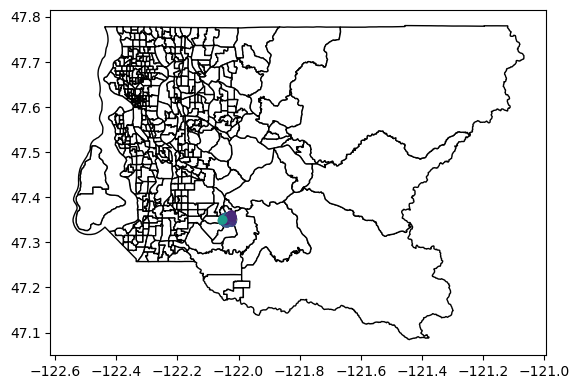

In [ ]:
# base will provide axes (ax)
base1 = census_tracts_king_co.plot(color='white', edgecolor='black') #.loc[census_tracts_king_co['TRACTCE20']=='031604']


#sales = sales_points.loc[sales_points['TRACTCE20']=='031604']

sales.plot(ax=base1, marker='o',c=sales_points['sale_price'],legend = True)

In [ ]:
sales_points['sale_price']

NameError: name 'sales_points' is not defined

In [ ]:
# next steps
# calc (with Pysal) spatial weights to test for spatial autocorrelation, for spatial regression, gwr?
# spreg ...
# look for ML algorithm?

AttributeError: module 'seaborn' has no attribute 'plot'